In [46]:
from utils.fast_cmod5n import *
from glob import glob
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from scipy import stats
import seaborn as sns


In [47]:
processed_data_path = Path("processed_data")
df_wv1 = pd.read_parquet(processed_data_path / 'wv1_complete.parquet')
df_wv2 = pd.read_parquet(processed_data_path / 'wv2_complete.parquet')

In [48]:
# columns that have matrices as entries

for col in df_wv1.columns:
    if isinstance(df_wv1[col].iloc[0], np.ndarray):
        print(col)

true_sigma0_row_var
true_sigma0_column_var
sigma0_cmod_row_var
sigma0_cmod_column_var


In [49]:
# all columns

df_wv1.columns

Index(['value', 'wm_type', 'lonlat_center', 'tif_path', 'process_status',
       'class_1', 'prob_1', 'class_2', 'prob_2', 'class_3', 'prob_3',
       'all_prob', 'processing_time', 'filename', 'date_time', 'latitude',
       'longitude', 'L', 'wspd', 'wdir', 'sst', 'airt', 'p', 'rh', 'blh',
       'msdwswrf', 'msdwlwrf', 'renamed_filename', 'exists_ok',
       'path_to_sar_file', 'spectral_stats', 'mean_sigma0', 'var_sigma0',
       'skewness_sigma0', 'kurtosis_sigma0', 'mean_psd2d', 'var_psd2d',
       'skewness_psd2d', 'kurtosis_psd2d', 'mean_psd_band0', 'var_psd_band0',
       'skewness_psd_band0', 'kurtosis_psd_band0', 'mean_psd_band1',
       'var_psd_band1', 'skewness_psd_band1', 'kurtosis_psd_band1',
       'mean_psd_band2', 'var_psd_band2', 'skewness_psd_band2',
       'kurtosis_psd_band2', 'wdir_deg_from_north', 'perturbed_wdir',
       'phi_nominal_median', 'phi_perturbed_median', 'ground_heading_median',
       'azimuth_look_median', 'true_sigma0_median', 'true_sigma0_row_v

In [55]:
# cleaning data of weird "true_sigma0_median" values

df_wv1 = df_wv1[df_wv1['true_sigma0_median'] > -1000]
df_wv2 = df_wv2[df_wv2['true_sigma0_median'] > -1000]

df_wv2.true_sigma0_median.describe()

count    36962.000000
mean         0.114680
std          0.085500
min          0.005835
25%          0.080956
50%          0.114323
75%          0.142889
max          5.752049
Name: true_sigma0_median, dtype: float64

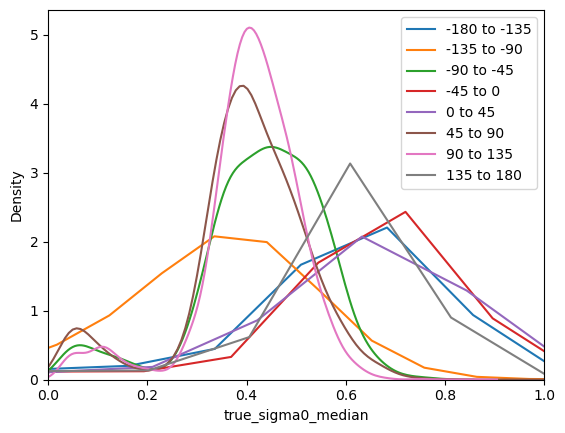

In [64]:
bin_edges = np.arange(-180, 181, 45)  
bin_labels = [f"{left} to {right}" for left, right in zip(bin_edges[:-1], bin_edges[1:])]

df_wv1['phi_bin'] = pd.cut(df_wv1['phi_nominal_median'], bins=bin_edges, 
                           labels=bin_labels, include_lowest=True, right=False)

binned_dfs = {}
for bin_label in bin_labels:
    binned_dfs[bin_label] = df_wv1[df_wv1['phi_bin'] == bin_label].copy()

for bin_label, df in binned_dfs.items():
    sns.kdeplot(df['true_sigma0_median'], label=bin_label)

plt.xlim(0,1)
plt.legend()
plt.show()

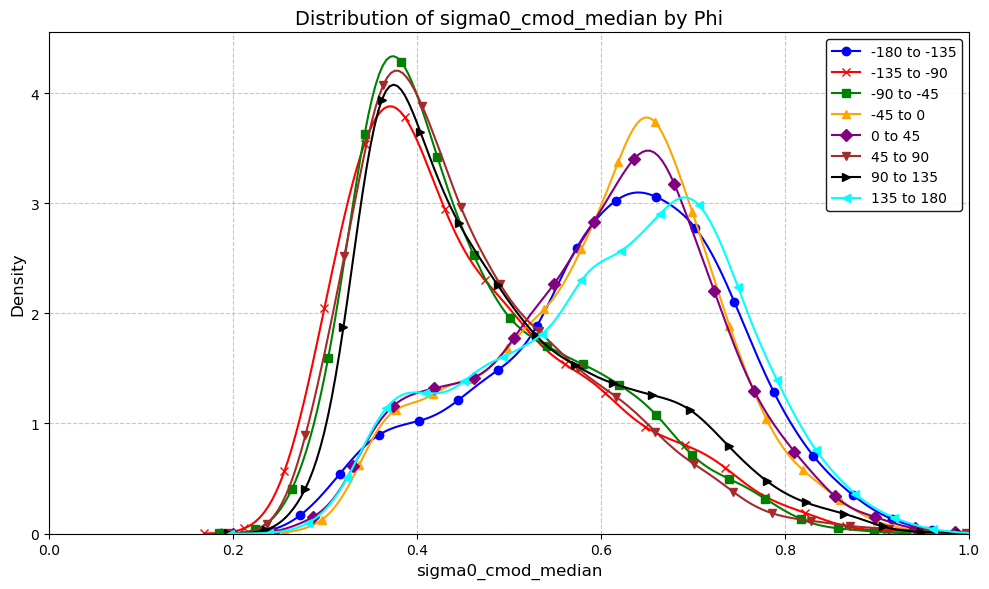

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Define a variety of markers, line styles, and colors for better distinction
markers = ['o', 'x', 's', '^', 'D', 'v', '>', '<']  # 8 different marker types
line_styles = ['-', '--', ':', '-.']  # 4 different line styles
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'black', 'cyan']  # 8 different colors

plt.figure(figsize=(10, 6))  # Larger figure for better visibility

# Create the plots with distinctive styles
for i, (bin_label, df) in enumerate(binned_dfs.items()):
    marker_idx = i % len(markers)
    ls_idx = (i // len(markers)) % len(line_styles)
    color_idx = i % len(colors)
    
    sns.kdeplot(
        df['sigma0_cmod_median'], 
        label=bin_label,
        marker=markers[marker_idx], 
        linestyle=line_styles[ls_idx],
        color=colors[color_idx],
        markevery=10  # Add markers periodically to avoid overcrowding
    )

# Add a clear title and axis labels
plt.title('Distribution of sigma0_cmod_median by Phi', fontsize=14)
plt.xlabel('sigma0_cmod_median', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Set the x-axis limit
plt.xlim(0, 1)

# Create a more visible and organized legend
plt.legend(loc='upper right', fontsize=10, framealpha=0.9, edgecolor='black')

# Add a grid for easier reading of values
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

,value,wm_type,lonlat_center,tif_path,process_status,class_1,prob_1,class_2,prob_2,class_3,...,sigma0_cmod_column_var,sigma0_cmod_skew,sigma0_cmod_kurtosis,wspd_median,wspd_var,wspd_skewness,wspd_kurtosis,residual,residual_normalized,phi_bin
172,15,wv1,-145.681915718 44.0278263401,/home/datawork-cersat-public/cache/public/ftp/...,OK,POS,0.997555,IB,0.001893,AF,...,"[5.8758112629575276e-08, 5.8545253458163804e-0...",0.146024,-1.174518,14.023438,5.393511e-04,2.704885,5.316405,-1.848952,-0.116489,-60 to -30
174,17,wv1,-146.181079922 42.271247523,/home/datawork-cersat-public/cache/public/ftp/...,OK,POS,0.996547,IB,0.002811,AF,...,"[5.5987511845904055e-08, 5.5765757576537174e-0...",0.135970,-1.177620,20.273438,1.483683e-03,-0.337285,-1.886239,2.168879,0.119797,-30 to 0
414,13,wv1,56.3452059747 -49.7595448547,/home/datawork-cersat-public/cache/public/ftp/...,OK,POS,0.998195,IB,0.001388,AF,...,"[2.4194898086488795e-07, 2.4088642258927915e-0...",0.146050,-1.174453,16.679688,0.000000e+00,NaN,NaN,0.010162,0.000610,0 to 30
416,15,wv1,55.5013010377 -48.047256985,/home/datawork-cersat-public/cache/public/ftp/...,OK,POS,0.992784,IB,0.004895,AF,...,"[2.039897990905711e-07, 2.0316495314997589e-07...",0.156863,-1.170622,10.351562,1.551086e-03,-0.295754,0.193282,-5.912194,-0.363520,0 to 30
540,9,wv1,-101.674351923 -57.318909724,/home/datawork-cersat-public/cache/public/ftp/...,OK,WS,0.458845,POS,0.441267,IB,...,"[3.612609712520394e-07, 3.598862027425039e-07,...",0.146133,-1.174373,19.335938,1.673174e-03,0.023504,-1.323471,2.245552,0.131393,0 to 30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720624,47,wv1,-93.2433415386 -55.4957254597,/home/datawork-cersat-public/cache/public/ftp/...,OK,POS,0.995901,IB,0.003562,AF,...,"[4.840612128724218e-07, 4.822138219288004e-07,...",0.142184,-1.175922,18.320312,0.000000e+00,NaN,NaN,0.603078,0.034039,-180 to -150
720626,49,wv1,-94.3793017458 -57.1785945787,/home/datawork-cersat-public/cache/public/ftp/...,OK,POS,0.997312,IB,0.002251,AF,...,"[3.134469319566718e-07, 3.1215311223776115e-07...",0.142098,-1.176043,19.492188,5.545752e-07,-104.889228,10999.750091,0.972610,0.052518,-180 to -150
720628,51,wv1,-95.6160799379 -58.8508025819,/home/datawork-cersat-public/cache/public/ftp/...,OK,POS,0.996666,IB,0.002510,AF,...,"[3.4519939738515237e-07, 3.4382110083330173e-0...",0.145643,-1.174738,16.601562,0.000000e+00,NaN,NaN,0.059698,0.003609,-180 to -150
720634,57,wv1,-100.129731802 -63.7831661238,/home/datawork-cersat-public/cache/public/ftp/...,OK,POS,0.976486,AF,0.015158,IB,...,"[5.442807148965331e-07, 5.424292637012147e-07,...",0.150315,-1.172953,15.820312,9.041208e-04,1.658546,0.750774,-0.806207,-0.048489,120 to 150
